### A Custom Estimator for a Convolutional Neural Network

Hello intrepid reader! In this notebook, we'll will add a function that uses ```tf.layers``` to build a vanilla CNN. This should achieve around 99% accuracy on MNIST (there is still plenty of room to improve). Have a look at the ```build_cnn``` function where we define the model. Aside from that (and changing our preprocessing to no longer 'flatten' the images, and to add a color channel dimension), the code otherwise remains unchanged. 

In [52]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import tensorflow as tf
import os
from tensorflow.python.keras.preprocessing import image

In [61]:
def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=1)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [64, 64])
        image.set_shape([64, 64, 1])
        d = dict(zip([input_name], [image])), label
        return d
    if labels is None:
        labels = [0]*len(filenames)
    labels = np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels


In [62]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './morph/colorSubset'

# The directory where we will
# store our smaller dataset
base_dir = './data/male_vs_female_300'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_male_dir = os.path.join(train_dir, 'male')
train_female_dir = os.path.join(train_dir, 'female')
test_male_dir = os.path.join(test_dir, 'male')
test_female_dir = os.path.join(test_dir, 'female')

input_name = 'x'

In [63]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [64]:
MALE_LABEL = 0
FEMALE_LABEL = 1
train_male = [os.path.join(train_male_dir, file_name) for file_name in os.listdir(train_male_dir)]
train_female = [os.path.join(train_female_dir, file_name) for file_name in os.listdir(train_female_dir)]
train_files = train_male + train_female
train_labels = [MALE_LABEL]*len(train_male)+[FEMALE_LABEL]*len(train_female)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_male = [os.path.join(test_male_dir, file_name) for file_name in os.listdir(test_male_dir)]
test_female = [os.path.join(test_female_dir, file_name) for file_name in os.listdir(test_female_dir)]
test_files = test_male + test_female
test_labels = [MALE_LABEL]*len(test_male)+[FEMALE_LABEL]*len(test_female)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

Sanity Check

(20, 64, 64, 1)


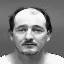

In [65]:
next_batch = imgs_input_fn(test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0]['x']

print(x_d.shape)
img = image.array_to_img(x_d[8])
img

In [73]:
x_l = first_batch[1]
print(x_l.shape)
print(x_l)

(20, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


This function that defines our CNN.

In [69]:
def build_cnn(features, mode):
    
    image_batch = features['x']
    
    with tf.name_scope("conv1"):  
        conv1 = tf.layers.conv2d(inputs=image_batch, filters=160, kernel_size=[3, 3],
                                 padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool1"):  
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    with tf.name_scope("conv2"):  
        conv2 = tf.layers.conv2d(inputs=pool1, filters=80, kernel_size=[3, 3],
                                 padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool2"):  
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    with tf.name_scope("dense"):  
        # The 'images' are now 7x7 (28 / 2 / 2), and we have 64 channels per image
        pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 80])
        dense = tf.layers.dense(inputs=pool2_flat, units=128, activation=tf.nn.relu)

    with tf.name_scope("dropout"):  
        # Add dropout operation; 0.8 probability that a neuron will be kept
        dropout = tf.layers.dropout(
            inputs=dense, rate=0.2, training = mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=2)

    return logits

To write a Custom Estimator we'll specify our own model function. Here, we'll use ```tf.layers``` to replicate the model from the third notebook.

In [70]:
def model_fn(features, labels, mode):
    
    logits = build_cnn(features, mode)
    
    # Generate Predictions
    classes = tf.argmax(logits, axis=1)
    predictions = {
        'classes': classes,
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Return an EstimatorSpec for prediction
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        
    # Compute the loss, per usual.
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=labels, logits=logits)
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        
        # Configure the Training Op
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=1e-3,
            optimizer='Adam')

        # Return an EstimatorSpec for training
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                      loss=loss, train_op=train_op)    

    assert mode == tf.estimator.ModeKeys.EVAL
    
    # Configure the accuracy metric for evaluation
    metrics = {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, axis=1))}
    
    return tf.estimator.EstimatorSpec(mode=mode, 
                                      predictions=predictions, 
                                      loss=loss,
                                      eval_metric_ops=metrics)

Input functions, as before.

In [71]:
estimator = tf.estimator.Estimator(model_fn=model_fn)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/fm/z2chdhwn5z3__xvw4bw758hm0000gn/T/tmpzdxkb1ga', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c29e7cfd0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [50]:
# If you are running on a machine without a GPU, this can take some time to train.
estimator.train(input_fn=lambda: imgs_input_fn(train_files,
                                  labels=train_labels,
                                  perform_shuffle=True,
                                  repeat_count=5,
                                  batch_size=10))

ValueError: Shapes (?, 2) and (?, 1) are incompatible

In [44]:
# Evaluate the estimator using our input function.
# We should see our accuracy metric below
# Tweaking with the params of the model, you can get >99% accuracy
evaluate_results = estimator.evaluate(input_fn=lambda: imgs_input_fn(test_files, 
                                   labels=test_labels, 
                                   perform_shuffle=False,
                                   batch_size=1))
print("Evaluation results")
for key in evaluate_results:
    print("   {}, was: {}".format(key, evaluate_results[key]))

INFO:tensorflow:Starting evaluation at 2018-03-22-01:25:52


INFO:tensorflow:Restoring parameters from /var/folders/fm/z2chdhwn5z3__xvw4bw758hm0000gn/T/tmp8rir9g7u/model.ckpt-1


INFO:tensorflow:Finished evaluation at 2018-03-22-01:25:52


INFO:tensorflow:Saving dict for global step 1: accuracy = 1.0, global_step = 1, loss = 0.0


Evaluation results
   accuracy, was: 1.0
   loss, was: 0.0
   global_step, was: 1


In [ ]:
# Here's how to print predictions on a few examples
MAX_TO_PRINT = 5

# This returns a generator object
predictions = estimator.predict(input_fn=test_input)
i = 0
for p in predictions:
    true_label = np.argmax(y_test[i])
    predicted_label = p['classes']
    print("Example %d. True: %d, Predicted: %s" % (i, true_label, predicted_label))
    i += 1
    if i == MAX_TO_PRINT: break